In [1]:
import numpy as np
import torch
from torch import nn,optim
import matplotlib.pyplot as plt
%matplotlib inline
from src.pydybm.time_series.rnn_gaussian_dybm import GaussianDyBM
from src.pydybm.base.generator import NoisySin
from src.pydybm.base.sgd import RMSProp
from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
N = 10 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

Shape of train and test datasets
torch.Size([500, 97, 1])
torch.Size([500, 3, 1])
torch.Size([100, 97, 1])
torch.Size([100, 3, 1])


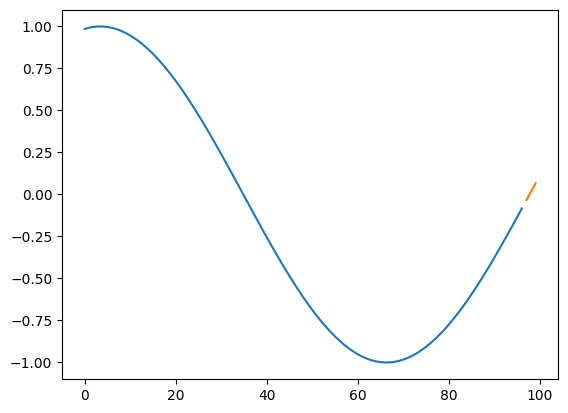

In [3]:
#preparing time windows
wind_size = 100
y_windowed = []
x_wind = []
y_wind = []

for i in range(wind_size,L):
    curr = y[:,i-wind_size:i]
    res = np.swapaxes(curr,0,1)
    x_wind.append(res[0:97])
    y_wind.append(res[-3:])

x_wind = np.array(x_wind)[:,:,0:1]
y_wind = np.array(y_wind)[:,:,0:1]

x_train = torch.from_numpy(x_wind[0:500])
y_train = torch.from_numpy(y_wind[0:500])
x_test = torch.from_numpy(x_wind[800:])
y_test = torch.from_numpy(y_wind[800:])
print("Shape of train and test datasets")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_axis_test = np.arange(0,100)
plt.plot(x_axis_test[0:97],x_wind[5,:,0])
plt.plot(x_axis_test[-3:],y_wind[5,:,0])
plt.show()

In [13]:
class GRBM(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(GRBM,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        """variance vector
        #variables["s"][n] corresponds to the standard deviation of
        out_pattern[n] (or scale parameter in other words)"""
        self.variable["s"] = torch.ones([1,out_dim],dtype=torch.float32)

class LSTM(nn.Module):
    def __init__(self, hidden_layers=97,lr_rate=0.005,dybm_in_dim=97,dybm_out_dim=3):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.SGD = RMSProp 
        self.dybm = GaussianDyBM(dybm_in_dim,out_dim=dybm_out_dim,delay=delay,decay_rates=[decay], SGD=self.SGD())
        self.dybm.set_learning_rate(lr_rate)
        self.predictions = list()
        self.actuals = list()
        # self.linear = nn.Linear(self.hidden_layers, 96)
        
    def return_results(self):
        return {"prediction": self.predictions, "actual": self.actuals}
    
    def forward(self,x_y, future_preds=0):
        outputs, n_samples = [], x_y[0].size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        h_t, c_t = self.lstm1(x_y[0], (h_t, c_t))

        prediction = self.dybm.predict_next()
        self.predictions.append(prediction)
        self.actuals.append(x_y[1].reshape(3))
        self.dybm.learn_one_step(x_y[1].reshape(3))
        self.dybm._update_state(h_t[-1].reshape(97))
        # h_t = h_t.view(-1, self.hidden_layers)
        # output = self.linear(h_t[-1])
        # outputs = []
        # for time_step in y.split(1, dim=1):
        #     # N, 1
        #     h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
        #     output = self.linear(h_t) # output from the last FC layer
        #     outputs.append(output)
            
        # for i in range(future_preds):
        #     # this only generates future predictions if we pass in future_preds>0
        #     # mirrors the code above, using last output/prediction as input
        #     h_t, c_t = self.lstm1(output, (h_t, c_t))
        #     output = self.linear(h_t)
        #     outputs.append(output)
        # # transform list to tensor    
        # outputs = torch.cat(outputs, dim=1)
        # return outputs[-1,:]
        # return output[:,None]
        # return output[:,None]
        return self.predictions[-1].reshape(3,1)

delay = 0
decay = 0.05
lr = 0.0005

model = LSTM(
    hidden_layers=97,
    lr_rate=lr,
    dybm_in_dim=97,
    dybm_out_dim=3)
criterion = nn.MSELoss()
# optimiser = optim.LBFGS(model.parameters(), lr=0.08)
# optimiser = optim.Adam(model.parameters(), lr=0.0005)
# optimiser = optim.SGD(model.parameters(), lr=0.001)
optimiser = optim.Adagrad(model.parameters(), lr=lr)

In [12]:
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999)
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999)

test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)

In [5]:
def MSE(y_true,y_pred):
    """
    Function to calculate the mean squared error of a sequence of predicted vectors
    
    y_true : array, shape(L,N)
    y_pred : array, shape(L,N)

    mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors (y_true[i],y_pred[i])
    """
    MSE_each_coordinate = mean_squared_error(y_true,y_pred,multioutput="raw_values")
    return np.sum(MSE_each_coordinate)

def RMSE(y_true,y_pred):
    """
    Function to calculate the root mean squared error of a sequence of predicted vectors
    
    y_true : array, shape(L,N)
    y_pred : array, shape(L,N)

    squared root of the mean of (dy_1^2 + ... + dy_N^2 ) over L pairs of vectors (y_true[i],y_pred[i])
    """
    return np.sqrt(MSE(y_true,y_pred))

In [6]:
def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss

        optimiser.zero_grad()
        total_loss = []
        predictions = []
        for (idx,x) in enumerate(x_train):
            # optimiser.step(closure)
            model.dybm.init_state() 
            out = model([x,y_train[idx]])
            loss = loss_fn(out, y_train[idx])
            loss.backward()
            optimiser.step()
            total_loss.append(loss.detach())
            predictions.append(out.detach()[-1].numpy())
        print("Median train loss :",np.array(total_loss).mean())
        # with torch.no_grad():
        #     future = 1000
        #     pred = model(test_input, future_preds=future)
        #     # use all pred samples, but only go to 999
        #     loss = loss_fn(pred[:, :-future], test_target)
        #     y = pred.detach().numpy()
        # draw figures
        # plt.figure(figsize=(12,6))
        # plt.title(f"Step {i+1}")
        # plt.xlabel("x")
        # plt.ylabel("y")
        # plt.xticks(fontsize=20)
        # plt.yticks(fontsize=20)
        # n = train_input.shape[1] # 999
        # def draw(yi, colour):
        #     plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
        #     plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        # draw(y[0], 'r')
        # draw(y[1], 'b')
        # draw(y[2], 'g')
        # plt.savefig("predict%d.png"%i, dpi=200)
        # plt.close()
        # # print the loss
        # out = model(train_input)
        # loss_print = loss_fn(out, train_target)
        # print("Step: {}, Loss: {}".format(i, loss_print))

In [15]:
training_loop(50,model,optimiser,criterion,x_train,y_train,x_test,y_test)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

In [88]:
test_0 = model(x_train[150]).detach().numpy()

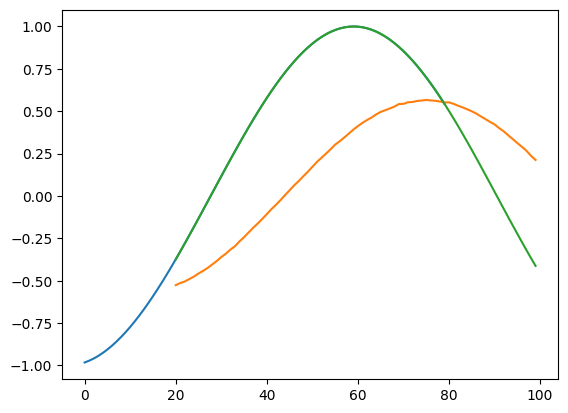

In [89]:
x_axis_test = np.arange(0,100)
plt.plot(x_axis_test[0:80],x_train[150])
plt.plot(x_axis_test[-80:],test_0)
plt.plot(x_axis_test[-80:],y_train[150])
plt.show()